<a href="https://colab.research.google.com/github/JuniorSilvaCosta/fpcc2Lab1/blob/main/Previs%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1- Analisar as distribuições das variáveis para ver se estão enviesadas e precisam de correção; tratamento de valores ausentes, variáveis categóricas e normalização, quando for o caso.

2- Construir modelos de regressão com (ridge e lasso) e sem regularização.

3- Considerar outros modelos ainda não vistos em sala de sua escolha (e.g. SVR, Regression Trees, KNN e Random Florests).

4- Tunar os hiperâmetros para cada caso e retornar os rmses de validação cruzada para todos os modelos avaliados.

5- Plotar os resíduos versus predições e analisar se esses plots representam bons indícios da adequabilidade dos modelos a esse problema.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
#dados = pd.read_csv("eleicoes_2006_a_2010.csv")
train = pd.read_csv("eleicoes_2006_a_2010.csv")
test = pd.read_csv("eleicoes_2014.csv")

In [3]:
#from sklearn.model_selection import train_test_split
#train, test = train_test_split(dados, train_size=0.8)

In [4]:
train.head()

,ano,sequencial_candidato,nome,uf,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos/comites,...,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,cargo,sexo,grau,estado_civil,ocupacao,votos
0,2006,10001,JOSÉ LUIZ NOGUEIRA DE SOUSA,AP,PT,6,6,16600.00,2766.666667,NaN,...,14,14,16583.60,1184.542857,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),VEREADOR,8579
1,2006,10002,LOIVA DE OLIVEIRA,RO,PT,13,13,22826.00,1755.846154,6625.0,...,24,23,20325.99,883.738696,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,SOLTEIRO(A),SERVIDOR PÚBLICO ESTADUAL,2757
2,2006,10002,MARIA DALVA DE SOUZA FIGUEIREDO,AP,PT,17,16,148120.80,9257.550000,2250.0,...,123,108,146011.70,1351.960185,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,VIÚVO(A),PEDAGOGO,17428
3,2006,10002,ROMALDO MILANI,MS,PRONA,6,6,3001.12,500.186667,NaN,...,8,8,3001.12,375.140000,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO INCOMPLETO,CASADO(A),MILITAR REFORMADO,1193
4,2006,10003,ANSELMO DE JESUS ABREU,RO,PT,48,48,NaN,NaN,NaN,...,133,120,116416.64,970.138667,DEPUTADO FEDERAL,MASCULINO,ENSINO FUNDAMENTAL COMPLETO,CASADO(A),DEPUTADO,29401


In [5]:
test.rename(columns={'nome_candidato': 'nome'}, inplace = True)
test.drop(['qtd_doacoes', 'qtd_doadores', 'recursos de outros candidatos/comitês', 'recursos de pessoas físicas', 'recursos de pessoas jurídicas', 'recursos próprios', 'qtd_despesas', 'qtd_fornecedores'], axis=1, inplace=True)
test.head()

,ano,sq_candidato,nome,sigla_uf,sigla_partido,total_receita,media_receita,total_despesa,media_despesa,descricao_cargo,sexo,grau_instrucao,estado_civil,descricao_ocupacao,votos
0,2014,10000000135,EMERSON DA SILVA SANTOS,AC,PSOL,1580.00,526.666667,1580.00,526.666667,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,SOLTEIRO(A),"CORRETOR DE IMÓVEIS, SEGUROS, TÍTULOS E VALORES",37
1,2014,10000000142,GERALDO SILVA DOS SANTOS,AC,PSOL,3180.00,636.000000,3130.02,626.004000,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,SOLTEIRO(A),VIGILANTE,383
2,2014,10000000158,CARLOS CESAR CORREIA DE MESSIAS,AC,PSB,333293.13,8770.871842,326869.78,2351.581151,DEPUTADO FEDERAL,MASCULINO,ENSINO FUNDAMENTAL INCOMPLETO,CASADO(A),OUTROS,26448
3,2014,10000000161,IDESIO LUIS FRANKE,AC,PT,156719.32,5404.114483,241016.07,1991.868347,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,CASADO(A),AGRÔNOMO,9896
4,2014,10000000163,LEONARDO CUNHA DE BRITO,AC,PT,711083.00,4870.431507,567401.15,1602.828107,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,CASADO(A),ADVOGADO,20876


In [6]:
all_data = pd.concat((train.loc[:,'nome':'votos'],
                      test.loc[:,'nome':'votos']))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f235d3f3050>,
      dtype=object)

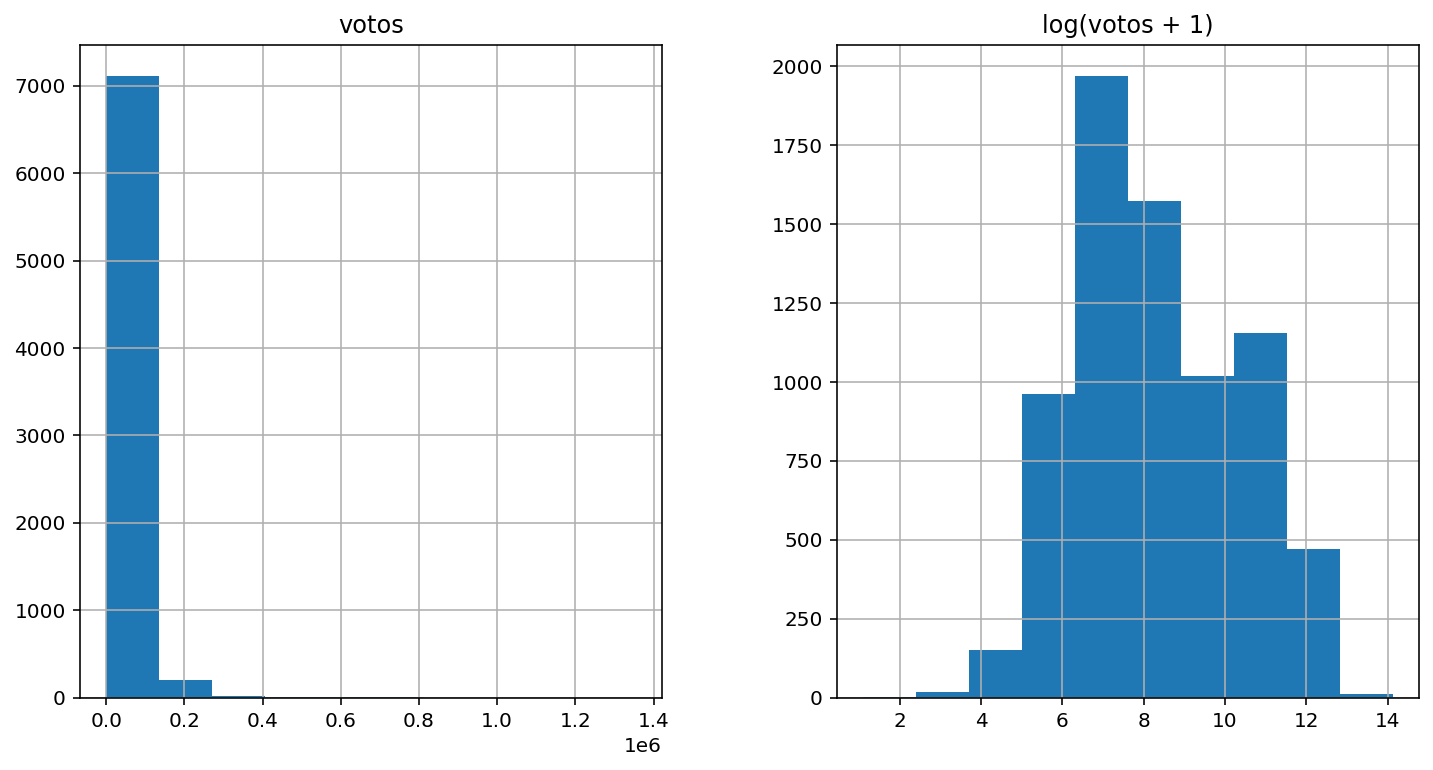

In [7]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"votos":train["votos"], "log(votos + 1)":np.log1p(train["votos"])})
prices.hist()

In [ ]:
#log transform the target:
train["votos"] = np.log1p(train["votos"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [ ]:
all_data = pd.get_dummies(all_data)

In [ ]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [ ]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.votos

In [ ]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [ ]:
model_ridge = Ridge()

In [ ]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0, 0.5, 'rmse')

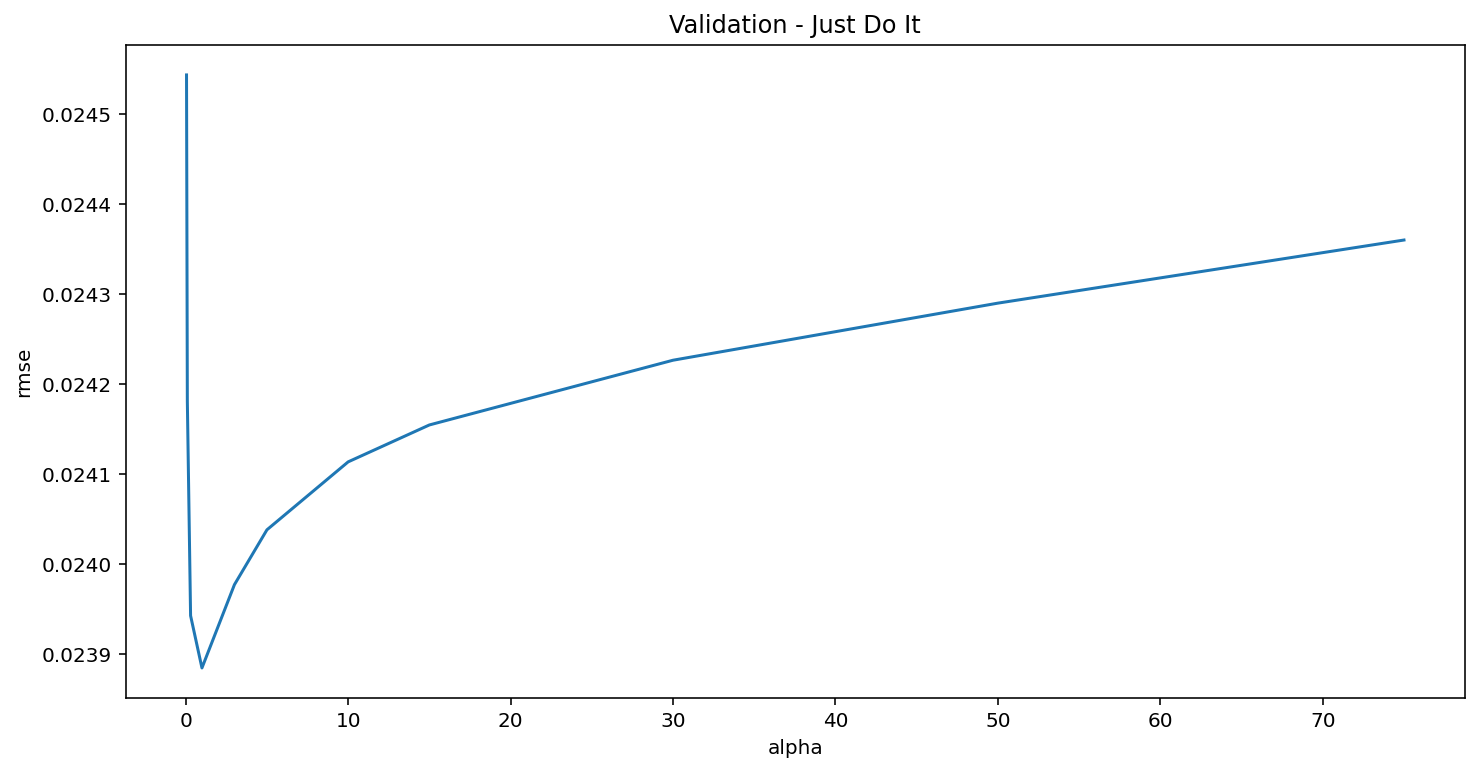

In [ ]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

Observe a curva em forma de U acima. Quando alfa é muito grande, a regularização é muito forte e o modelo não consegue capturar todas as complexidades dos dados. Se, no entanto, deixarmos o modelo muito flexível (alfa pequeno), o modelo começa a se ajustar demais. Um valor de alfa = 10 está quase certo com base no gráfico acima.

In [ ]:
cv_ridge.min()

0.023884832580593936

Assim, para a regressão de Ridge, obtemos um rmsle de cerca de 0.023. Vamos experimentar o modelo Lasso. Faremos uma abordagem um pouco diferente aqui e usaremos o Lasso CV integrado para descobrir o melhor alfa para nós.Por alguma razão, os alfas em Lasso CV são realmente o inverso ou os alfas em Ridge.

In [ ]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

In [ ]:
rmse_cv(model_lasso).mean()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.548e+02, tolerance: 1.445e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.244e+03, tolerance: 1.445e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

0.9043492853715029

O Ridge tem um desempenho ainda melhor, então vamos usar este para prever no conjunto de teste. Outra coisa legal sobre o Lasso é que ele faz seleção de recursos para você - definindo coeficientes de recursos que ele considera sem importância para zero. Vejamos os coeficientes:

In [ ]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [ ]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 11 variables and eliminated the other 11399 variables


Ridge se mostra melhor. Uma coisa a notar aqui, no entanto, é que os recursos selecionados não são necessariamente os "corretos" - especialmente porque há muitos recursos colineares neste conjunto de dados. Uma ideia para tentar aqui é executar o Lasso algumas vezes em amostras com boostrap e ver quão estável é a seleção de recursos.

Também podemos dar uma olhada diretamente em quais são os coeficientes mais importantes:

In [ ]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

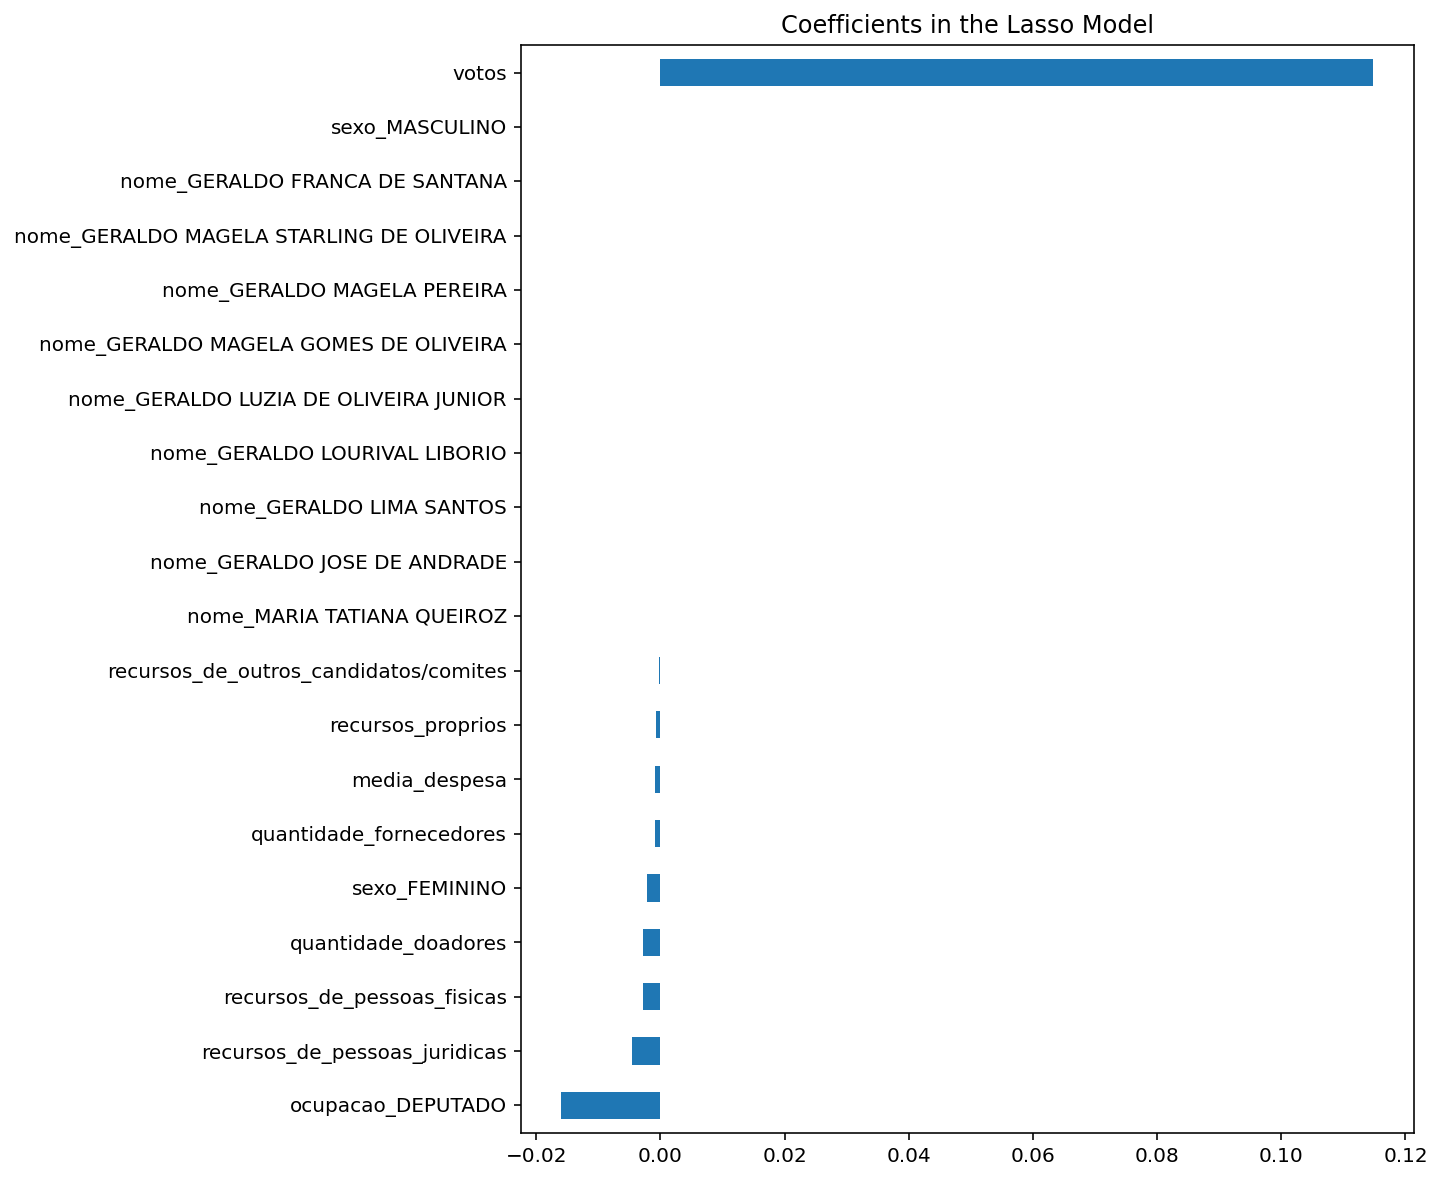

In [ ]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

A característica positiva mais importante é uf_CE - a área acima do solo por área de pés quadrados. Isso definitivamente sentido. Em seguida, alguns outros recursos de localização e qualidade contribuíram positivamente. Alguns dos recursos negativos fazem menos sentido e valeria a pena investigar mais - parece que eles podem vir de variáveis categóricas desequilibradas.

Observe também que, diferentemente da importância do recurso que você obteria de uma floresta aleatória, esses são coeficientes reais em seu modelo - para que você possa dizer precisamente por que o preço previsto é o que é. O único problema aqui é que nós log_transformamos tanto o alvo quanto os recursos numéricos para que as magnitudes reais sejam um pouco difíceis de interpretar.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LassoCV was fitted with feature names
  "X does not have valid feature names, but"


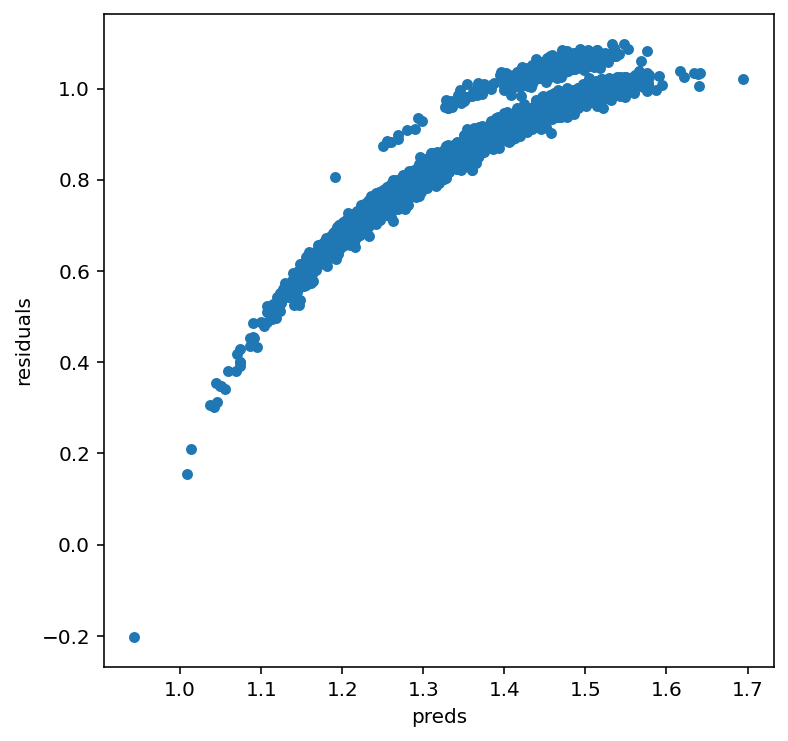

In [ ]:
#vamos olhar para os resíduos também:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

O gráfico residual parece muito bom. Para finalizar, vamos prever no conjunto de teste e enviar no placar:




Modelo xgboost: Vamos adicionar um modelo xgboost ao nosso modelo linear para ver se podemos melhorar nossa pontuação:

In [ ]:
import xgboost as xgb

In [ ]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

KeyboardInterrupt: ignored

In [ ]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

AttributeError: ignored

In [ ]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #Os parametros foram tunados utilizando xgb.cv
model_xgb.fit(X_train, y)

[20:56:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


KeyboardInterrupt: ignored

In [ ]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in expm1
  


In [ ]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fce5d116560> (for post_execute):


IndexError: ignored

IndexError: ignored

Muitas vezes faz sentido tomar uma média ponderada de resultados não correlacionados - isso geralmente melhora a pontuação, embora neste caso não ajude muito.

In [ ]:
preds = 0.7*lasso_preds + 0.3*xgb_preds

In [ ]:
solution = pd.DataFrame({"sequencial_candidato":test.sequencial_candidato, "votos":preds})
solution.to_csv("ridge_sol.csv", index = False)

AttributeError: ignored

Experimentando keras? As redes neurais de feedforward não parecem funcionar bem

In [ ]:
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
X_train = StandardScaler().fit_transform(X_train)

In [ ]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y, random_state = 3)

In [ ]:
X_tr.shape

(5497, 11410)

In [ ]:
X_tr

array([[-0.32528339, -0.27417183, -0.45269453, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.20347323,  0.26482314,  1.25189673, ...,  0.        ,
         0.        ,  0.        ],
       [-0.72062877, -0.67717231, -0.00536525, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.35683372,  0.37214317, -0.45243106, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.01577517, -0.38866715, -0.366772  , ...,  0.        ,
         0.        ,  0.        ],
       [-0.32528339, -0.27417183, -0.1542154 , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
model = Sequential()
model.add(Dense(256, activation="relu", input_dim = X_train.shape[1]))
#model.add(Dense(1, input_dim = X_train.shape[1], W_regularizer=l1(0.001)))

model.compile(loss = "mse", optimizer = "adam")

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2921216   
                                                                 
Total params: 2,921,216
Trainable params: 2,921,216
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist = model.fit(X_tr, y_tr, validation_data = (X_val, y_val))

172/172 [==============================] - 5s 27ms/step - loss: 4.0015 - val_loss: 4.6978


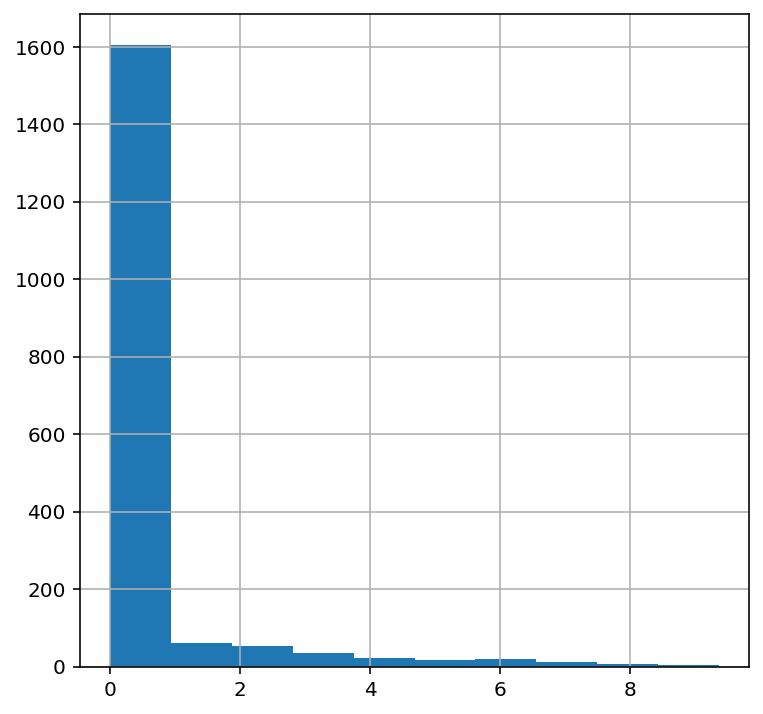

In [ ]:
pd.Series(model.predict(X_val)[:,0]).hist()

4- Responder:
Dentre os modelos avaliados, qual foi o que deu o melhor resultado nos dados de 2014 em termos de RMSE? Justifique bem sua resposta.

O modelo Ridge aparentemente se mostrou melhor, visto que possui RMSE de cerca de 0.023 raiz quadratica média dos erros